# **DATA301 Project**
**Name**: Robert Ivill

**ID**: 46012819

## **Research Question**: "Can we categorize streamers based on their viewer engagement and streaming activities?"



First we have to load the data into a dask dataframe:

In [52]:
import urllib.request
filename = '100k_a.csv'
urllib.request.urlretrieve('https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/twitch/100k_a.csv', filename)

('100k_a.csv', <http.client.HTTPMessage at 0x7b248f048070>)

In [53]:
import dask.dataframe as dd
df = dd.read_csv('100k_a.csv',blocksize=1e6) # 1MB blocksize
print(df.head())
df

   1  33842865744     mithrain  154  156
0  1  33846768288        alptv  166  169
1  1  33886469056     mithrain  587  588
2  1  33887624992         wtcn  589  591
3  1  33890145056    jrokezftw  591  594
4  1  33903958784  berkriptepe  734  737


,1,33842865744,mithrain,154,156
npartitions=114,,,,,
,int64,int64,string,int64,int64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


Next, we tidy up the dataframe by adding column names, dropping missing data and adding relevant columns for our research question.

In [54]:
new_columns = ['UserID', 'StreamID', 'StreamerID', 'TimeStart', 'TimeFinish']
df = df.rename(columns=dict(zip(df.columns, new_columns)))
df.head() # Now the dataframe has helpful column names

,UserID,StreamID,StreamerID,TimeStart,TimeFinish
0,1,33846768288,alptv,166,169
1,1,33886469056,mithrain,587,588
2,1,33887624992,wtcn,589,591
3,1,33890145056,jrokezftw,591,594
4,1,33903958784,berkriptepe,734,737


In [55]:
df = df.dropna(subset=df.columns[:]) # Remove missing values

In [56]:
df['WatchTime'] = (df['TimeFinish'] - df['TimeStart']) # Create a Watch Time column (10 min and seconds scale)
df['WatchTime(s)'] = (df['TimeFinish'] - df['TimeStart']) * 600
df.head()

,UserID,StreamID,StreamerID,TimeStart,TimeFinish,WatchTime,WatchTime(s)
0,1,33846768288,alptv,166,169,3,1800
1,1,33886469056,mithrain,587,588,1,600
2,1,33887624992,wtcn,589,591,2,1200
3,1,33890145056,jrokezftw,591,594,3,1800
4,1,33903958784,berkriptepe,734,737,3,1800


To categorize streamers, we need to create a dataframe that groups by each streamer and their find the respective features we need.

In [57]:
import pandas as pd

# Group by 'StreamerID' and calculate the mean 'WatchTime' per user
watch_time = df.groupby('StreamerID')['WatchTime'].mean().compute()

# Group by 'StreamerID' and count 'StreamID' for the total number of user-streamer interactions
total_interactions = df.groupby('StreamerID')['StreamID'].count().compute()

# Group by 'StreamerID' and count unique 'StreamID' for the total number of streams per streamer
total_streams = df.drop_duplicates(subset=['StreamerID', 'StreamID']).groupby('StreamerID')['StreamID'].count().compute()

# Group by 'StreamerID' and count unique 'StreamID' for the total number of unique viewers per streamer
unique_users = df.drop_duplicates(subset=['StreamerID', 'UserID']).groupby('StreamerID')['UserID'].count().compute()

# Combine the results into a single DataFrame
streamer_features = pd.DataFrame({
    'WatchTime': watch_time,
    'UniqueUsers': unique_users,
    'TotalStreams': total_streams,
    'TotalInteractions': total_interactions
})

# Display the top streamers by their unique users
top_unique_users = streamer_features.sort_values('UniqueUsers', ascending=False)

top_unique_users.head()

,WatchTime,UniqueUsers,TotalStreams,TotalInteractions
StreamerID,,,,
ninja,2.469741,17154,40,45144
tfue,2.657764,14460,35,40136
shroud,2.738616,11011,43,27362
riotgames,4.034934,7747,39,17633
sodapoppin,3.581905,5982,32,14590


It is important to scale our results as this allows us to see better results when comparing the clusters. The SciKit Scaler module will scale each feature into a normal standard distribution for improved analysis.

In [58]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(streamer_features)
features_scaled_df = pd.DataFrame(scaled_features, columns=streamer_features.columns)
features_scaled_df.head() # We see that some streamers have negative feature values,
# This means they perform below average within the distribution of all streamers

,WatchTime,UniqueUsers,TotalStreams,TotalInteractions
0,0.000000,0.000058,0.002801,0.000022
1,0.000000,0.000000,0.000000,0.000000
2,0.137255,0.000000,0.000000,0.000000
3,0.013072,0.000000,0.005602,0.000044
4,0.000000,0.000000,0.000000,0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

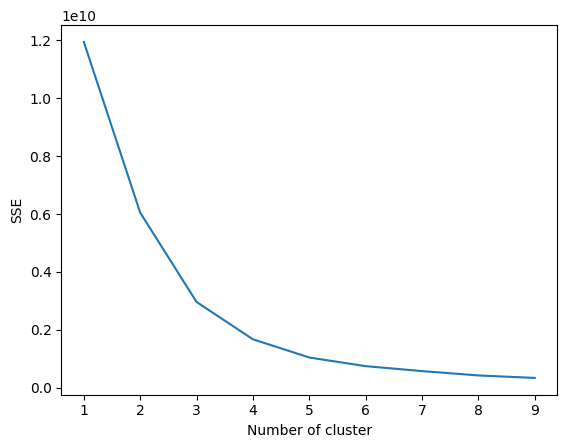

In [65]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
sse = {}
for k in range(1, 10): # Iterate over possible number of clusters
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(streamer_features)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE") # Plot the graph to find the elbow point.
plt.show()

Now we can use the SciKit KMeans module to performing clustering of our data, then visualise our results using matplotlib and seaborn.

In [66]:
from sklearn.cluster import KMeans

# Apply k-means clustering
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(streamer_features[['WatchTime', 'UniqueUsers', 'TotalStreams', 'TotalInteractions']])

# Add cluster labels to the original features
streamer_features['Cluster'] = clusters
streamer_features.head()

# Apply k-means clustering
kmeans = KMeans(n_clusters=4, random_state=0)
clusters_scaled = kmeans.fit_predict(features_scaled_df[['WatchTime', 'UniqueUsers', 'TotalStreams', 'TotalInteractions']])

# Add cluster labels to the original features
features_scaled_df['Cluster'] = clusters_scaled
features_scaled_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,WatchTime,UniqueUsers,TotalStreams,TotalInteractions,Cluster
0,0.000000,0.000058,0.002801,0.000022,0
1,0.000000,0.000000,0.000000,0.000000,0
2,0.137255,0.000000,0.000000,0.000000,1
3,0.013072,0.000000,0.005602,0.000044,0
4,0.000000,0.000000,0.000000,0.000000,0


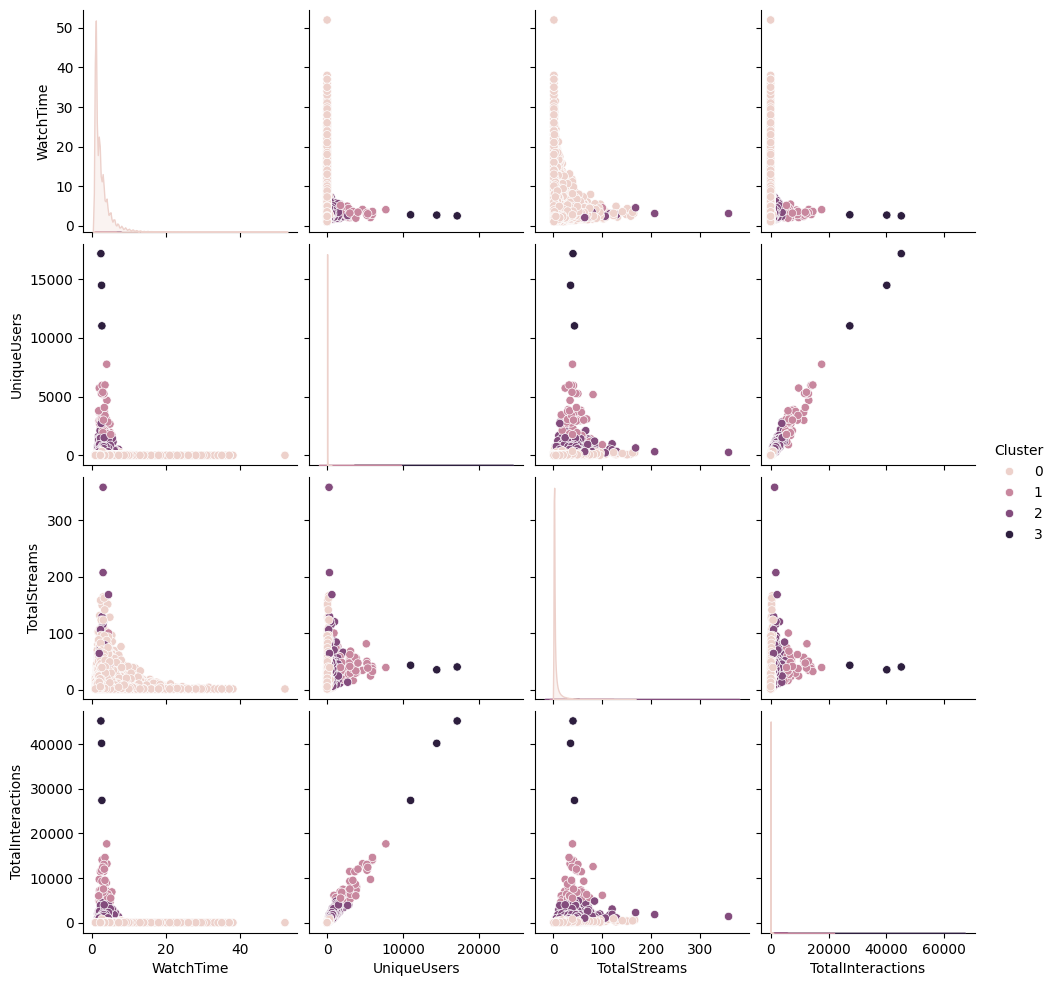

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(streamer_features, hue='Cluster')
plt.show() # Gives us a pair plot of each feature against each other, showing the different clusters as well.

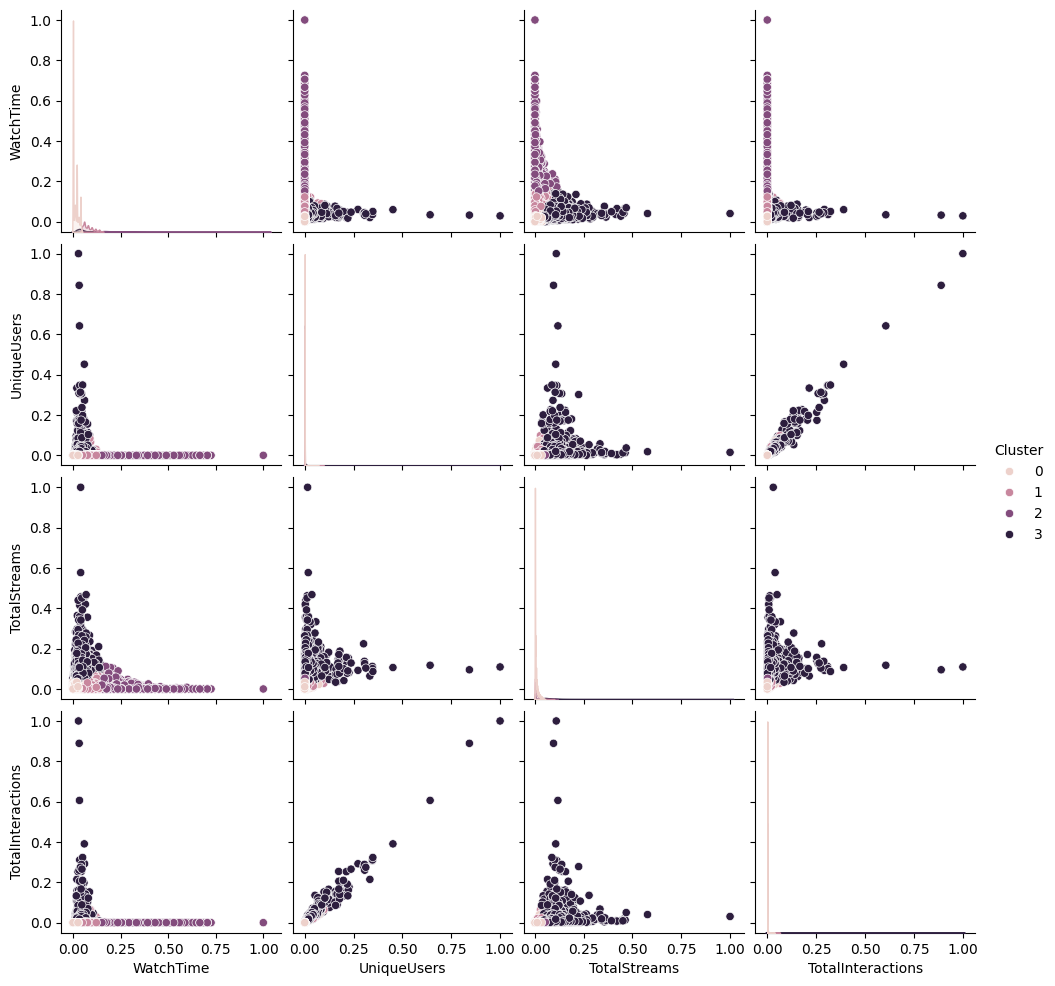

In [62]:
sns.pairplot(features_scaled_df, hue='Cluster')
plt.show() # Gives us a pair plot of each feature against each other, showing the different clusters as well.

In [69]:
pd.set_option('display.width', 180) #makes the output wider for easier viewing
# Analyze the clusters
for cluster in range(4):
    cluster_data = streamer_features[streamer_features['Cluster'] == cluster]
    print(f"Cluster {cluster}:")
    print(cluster_data.describe()) # shows the various statistics for each cluster.

Cluster 0:
           WatchTime    UniqueUsers   TotalStreams  TotalInteractions   Cluster
count  162118.000000  162118.000000  162118.000000      162118.000000  162118.0
mean        2.694982       5.978448       4.431587          10.725589       0.0
std         2.511540      22.502799       7.410929          45.302153       0.0
min         1.000000       1.000000       1.000000           1.000000       0.0
25%         1.000000       1.000000       1.000000           1.000000       0.0
50%         2.000000       1.000000       2.000000           2.000000       0.0
75%         3.214286       3.000000       4.000000           5.000000       0.0
max        52.000000     583.000000     166.000000         910.000000       0.0
Cluster 1:
       WatchTime  UniqueUsers  TotalStreams  TotalInteractions  Cluster
count  53.000000    53.000000     53.000000          53.000000     53.0
mean    3.315737  3205.981132     44.056604        7968.358491      1.0
std     0.883841  1476.824146     16.75090

In [70]:
# Analyze the scaled clusters
for cluster in range(4):
    cluster_data = features_scaled_df[features_scaled_df['Cluster'] == cluster]
    print(f"Cluster {cluster}:")
    print(cluster_data.describe()) # shows the various statistics for each cluster.

Cluster 0:
           WatchTime    UniqueUsers   TotalStreams  TotalInteractions   Cluster
count  116172.000000  116172.000000  116172.000000      116172.000000  116172.0
mean        0.011436       0.000104       0.004561           0.000061       0.0
std         0.013623       0.000608       0.008038           0.000307       0.0
min         0.000000       0.000000       0.000000           0.000000       0.0
25%         0.000000       0.000000       0.000000           0.000000       0.0
50%         0.004902       0.000000       0.000000           0.000000       0.0
75%         0.019608       0.000058       0.005602           0.000044       0.0
max         0.045752       0.071999       0.050420           0.038965       0.0
Cluster 1:
          WatchTime   UniqueUsers  TotalStreams  TotalInteractions  Cluster
count  30765.000000  30765.000000  30765.000000       30765.000000  30765.0
mean       0.079823      0.000173      0.008690           0.000130      1.0
std        0.026553      0.001